In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import nilearn
import os

from nilearn.datasets import fetch_haxby
from nilearn import input_data, plotting, image
from matplotlib import colors
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.plotting.img_plotting import plot_epi, plot_roi
import nibabel as nib

from utils import extract_segments, show_scan_slices
from dataloader import haxby_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
warnings.filterwarnings('ignore')

### [Haxby datset](http://www.pymvpa.org/datadb/haxby2001.html)

Во время эксперимента испытуемым показывали различные изображения. Категории изображений представляются в метках, а именно каждая метка соответствует определенной категории изображений. Например, если в эксперименте использовались изображения различных объектов, метки могут обозначать какие-то определенные объекты. Таким образом, задача классификации заключается в том, чтобы по фМРТ-снимкам предсказать, какой класс картинок наблюдал испытуемый.

Классы:
- bottle
- cat
- chair
- face
- house
- scissors
- scrambledpix
- shoe

Также присутствует rest, когда испытуемому ничего не показывали

In [7]:
dataset = haxby_dataset()

# Пути к файлам датасета
datafiles = dataset.data_files

# Описание датасета
#print(datafiles['description'])

# Отрисовка примеров стимулов
#dataset.plot_stimuli()

Получим данные первого испытуемого

In [8]:
fmris, labels = dataset.get_sub_data(1)

In [9]:
fmris.shape

(40, 64, 64, 1452)

In [10]:
labels.head()

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


---

### Маски активности
A common operation in fMRI analyses is masking: extracting particular voxels from the entire dataset, usually based on a binary brain mask. Masking, at least in fMRI analyses, is often done on the spatial dimensions of 4D images; as such, masking can be seen as a operation that takes in a 4D image with spatial dimensions  X×Y×Z  and temporal dimension  T  and returns a  T×K  2D array, where  K  is the number of voxels that "survived" (for lack of a better word) the masking procedure.

Reasons to mask your data could be, for example, to exclude non-brain voxels (like in skullstripping) or to perform confirmatory region-of-interest (ROI) analyses, or to extract one or multiple "seed regions" for connectivity analyses.

Nilearn provides several functions and classes that perform masking, which differ in how extensive they are (some only perform masking on a single image, others do this for multiple images at the same time, and/or may additionally perform preprocessing steps). Importantly, all take in a 4D niimg-like object and return a 2D numpy array.

We'll first take a look at the most simple and low-level implementation: apply_mask. This function takes in a 4D image (which will be masked), a binary 3D image (i.e., with only zeros and ones, where ones indicate that they should be included) as mask, and optionally a smoothing kernel size (FWHM in millimeters) and returns a masked 2D array. Let's do this for our data (func_img_run1) using the brain mask (func_mask) you computed earlier.

The ventral temporal cortex. Эта маска была создана в рамках исследования Haxby(2001) и выделяет часть мозга, специализирующуюся на обработке визуальной информации, и которая содержит области, чувствительные к различным типам категорий изображений. Далее проводим анализ для первого испытуемого

In [19]:
vt_mask_filename = load_img(datafiles.mask_vt[0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

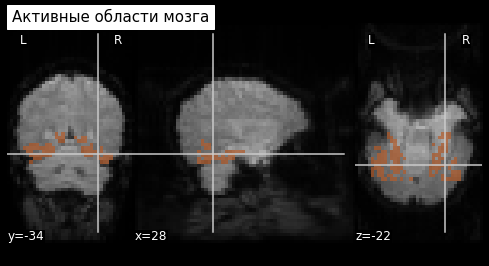

In [20]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

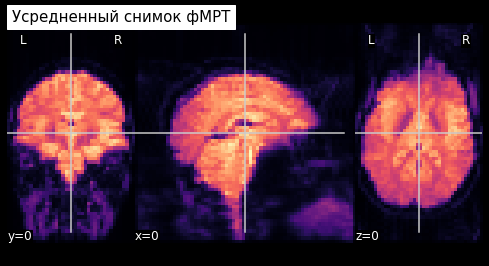

In [398]:
plot_epi(mean_haxby, cut_coords=(0, 0, 0), cmap='magma', title = 'Усредненный снимок фМРТ')

In [197]:
# Применение маски активации к фмрт снимкам
masker = input_data.NiftiMasker(mask_img=vt_mask_filename, standardize=True)
fmri_masked = masker.fit_transform(func_filename)

In [153]:
fmri_masked.shape

(1452, 577)

---

### Подготовка данных
Данные первого испытуемого хранятся в переменных fmris, labels, разделим последовательность на временные ряды по классам.
Закодируем классы следующим образом: 
- 'rest': 0
- 'bottle': 1
- 'cat': 2
- 'chair': 3
- 'face': 4
- 'house': 5
- 'scissors': 6
- 'scrambledpix': 7
- 'shoe': 8

Также обратим внимание на строение данных, до показа стимула и после показа стимула идет около 5 моментов времени отдыха. Сам же стимул демонстрируется ровно 9 моментов времени, поэтому зафиксируем $\tau = 19$.

По ссылке на haxby можно увидеть, что частота $\mu = 2.5$Гц

In [13]:
class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}

stimuli = np.array([class_dict[label] for label in labels['labels'].values])
stimuli.shape

(1452,)

In [14]:
fmris_transposed = fmris.transpose((3, 0, 1, 2))
fmris_transposed.shape

(1452, 40, 64, 64)

In [15]:
# Как мы видим тензоры фМРТ не нормированы
np.max(fmris_transposed[0])

2672.0

In [16]:
# Сегментация временного ряда по классам стимулов
X, s, y = extract_segments(fmris_transposed, stimuli, tau=19)

Всего получили 96 временных рядов фМРТ длины 19, на каждый класс приходится по 12 рядов. Возможна новая проблема аугментации, которая требует отдельного решения.

---
### Тестирование метода cross-corralation weighting

In [208]:
import torch
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def ccw(X, s, mu, k_s, Delta_t, h, get_corr=False, device='cpu'):
    # 1. Input: temporal fMRI series X with sampling rate mu and stimulus time series s
    X = torch.tensor(X, device=device) # (tau, X, Y, Z)
    s = torch.tensor(s, device=device) # (tau,)

    # 2. 3D Average Pooling
    X_prime = F.avg_pool3d(X, kernel_size=k_s) # (tau, X/k_s, Y/k_s, Z/k_s)

    # 3. Z-normalization of time series
    X_prime_hat = ((X_prime - X_prime.mean(dim=0, keepdims=True)) / (X_prime.std(dim=0) + 1e-9)).float()
    s_hat = ((s.float() - s.float().mean()) / s.float().std()).float()

    # 4. Cross-correlation computation
    tau = X_prime_hat.shape[0]
    C = torch.zeros((tau-1, X_prime_hat.shape[1], X_prime_hat.shape[2], X_prime_hat.shape[3]), device=device)
    for p in range(tau-1):
        C[p] = torch.einsum('i,itxy->txy', s_hat[:tau-p], X_prime_hat[p:]) / (tau-1)
        
    # 5. BOLD Delay and mask computation
    p_BOLD = int(np.floor(Delta_t * mu))
    C_p_BOLD = C[p_BOLD]
    _, top_h_indices = torch.topk(C_p_BOLD.view(-1), h)
    M_c = torch.zeros_like(C_p_BOLD)
    M_c.view(-1)[top_h_indices] = 1
    
    # 6. Upsample
    M = F.upsample(M_c.unsqueeze(0).unsqueeze(0), size=(X.shape[1], X.shape[2], X.shape[3]), mode='nearest')
    M = M.squeeze(0).squeeze(0)

    if get_corr:
        return M, C_p_BOLD
    else:
        return M

#### Пример применения метода на всем временном ряду испытуемого:

In [176]:
# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 100

bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1


# Get active mask using CCW method
active_mask = ccw(fmris_transposed, bin_stimuli, mu, k_s, Delta_t, h)

In [55]:
active_mask[active_mask==1].shape

torch.Size([1280])

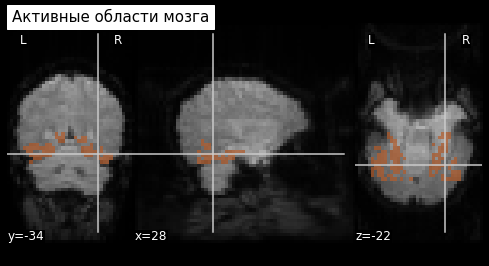

In [49]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

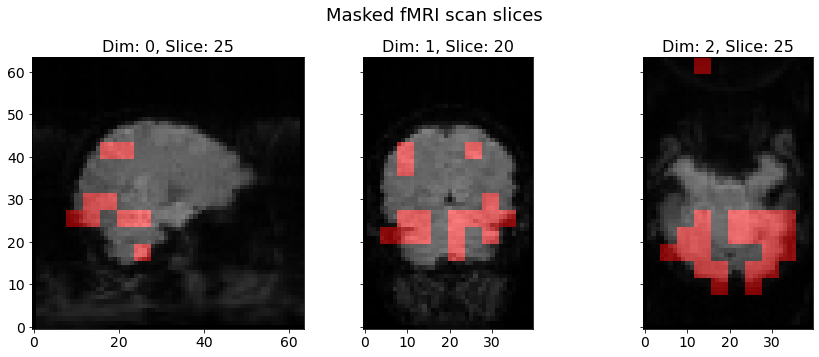

In [177]:
show_scan_slices(fmris_transposed[0], [25, 20, 25], active_mask, save_img=True)

---
#### Применим метод на небольшом временному ряду фМРТ, который соотвествует определенному стимулу:

#### Cat

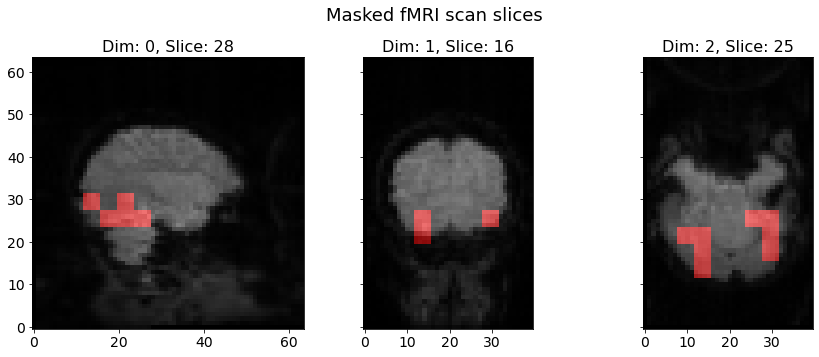

In [60]:
fMRI_cat = X[12]
s_cat = s[12]

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 20

s_cat[s_cat!=0]=1

# Get active mask using CCW method
active_mask= ccw(fMRI_cat, s_cat, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_cat[10], [28, 16, 25], active_mask, save_img=False)

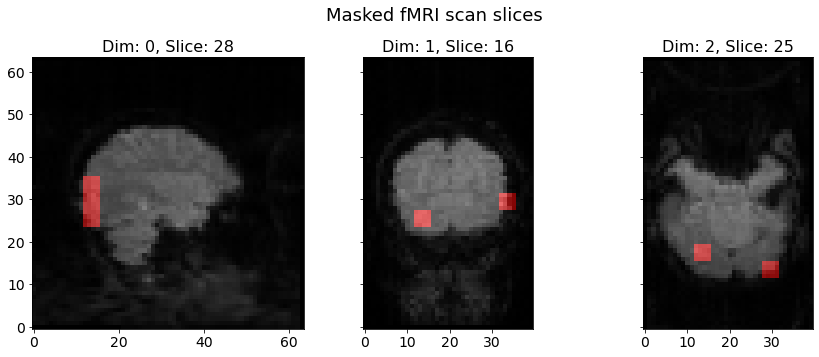

In [68]:
fMRI_cat = X[20]
s_cat = s[20]

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 5

s_cat[s_cat!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_cat, s_cat, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_cat[10], [28, 16, 25], active_mask, save_img=False)

#### Bottle

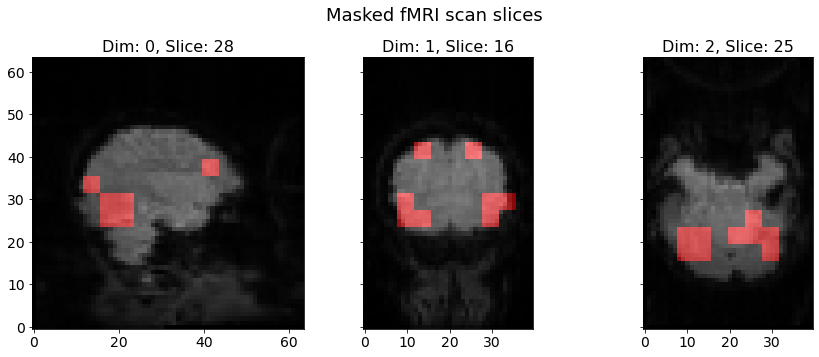

In [69]:
fMRI_bottle = X[0]
s_bottle = s[0]

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 30

s_bottle[s_bottle!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_bottle, s_bottle, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_bottle[10], [28, 16, 25], active_mask, save_img=False)

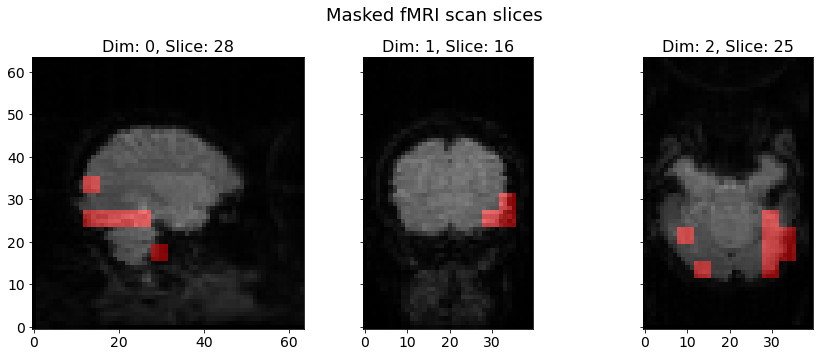

In [77]:
fMRI_bottle = X[4]
s_bottle = s[4]

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 15

s_bottle[s_bottle!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_bottle, s_bottle, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_bottle[10], [28, 16, 25], active_mask, save_img=False)

#### Faces

In [78]:
vt_mask_filename = load_img(datafiles['mask_face'][0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

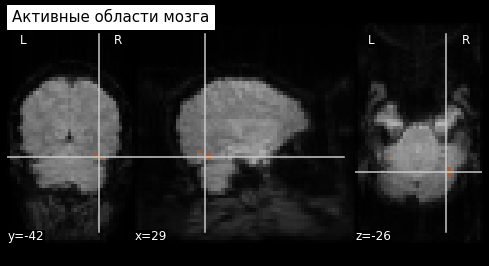

In [79]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

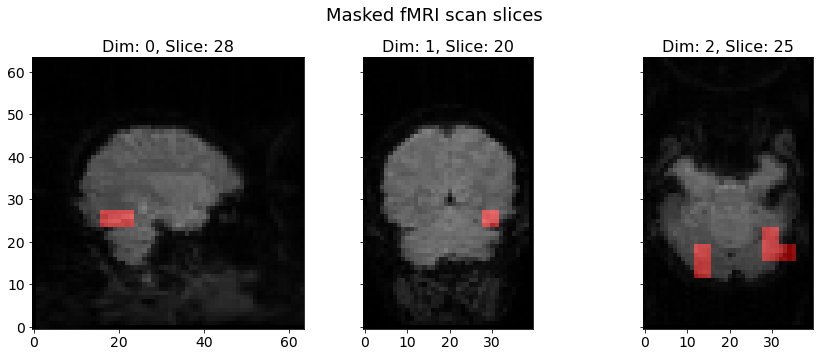

In [86]:
fMRI_face = X[40]
s_face = s[40]

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 9

s_face[s_face!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_face, s_face, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_face[10], [28, 20, 25], active_mask, save_img=False)

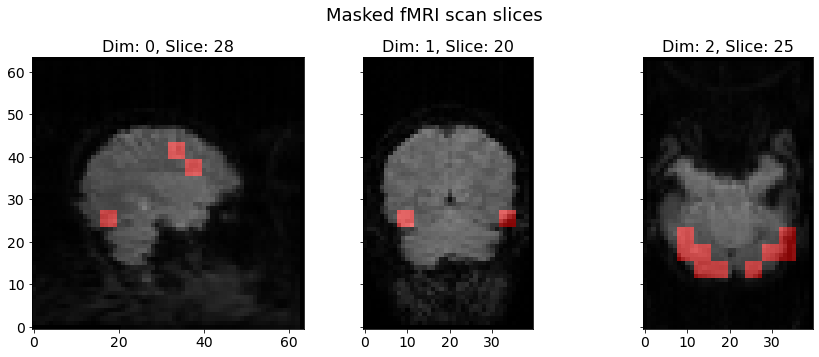

In [201]:
fMRI_face = X[47]
s_face = s[47]
    
# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 20

s_face[s_face!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_face, s_face, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_face[10], [28, 20, 25], active_mask, save_img=False)

----

#### Корректность
Эксперимент с шумом, проверим, что выделение областей не случайно, возьмем в качестве вектора стимулов рандомный набор единиц и нулей:

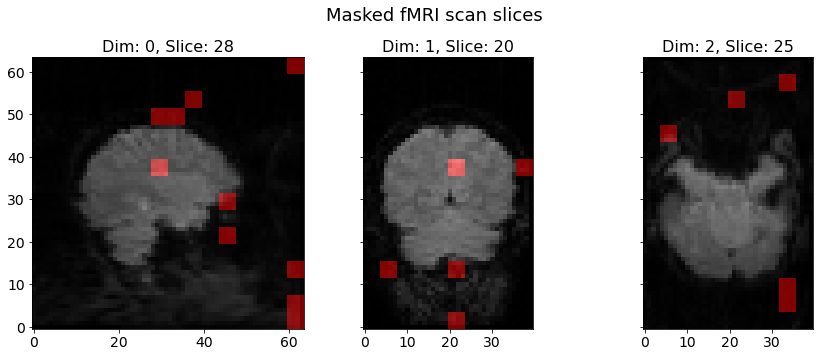

In [152]:
fMRI_face = X[47]
np.random.seed(4)
rand_s = np.random.randint(0, 2, size=fMRI_face.shape[0])

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 100

rand_s[rand_s!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_face, rand_s, mu, k_s, Delta_t, h)


show_scan_slices(fMRI_face[10], [28, 20, 25], active_mask, save_img=False)

---

#### Сегментация мозга

In [251]:
from skimage import morphology

# Выбираем временной ряд фМРТ в виде 4D-массива NumPy
# Вычисляем среднее изображение по всему временному ряду
mean_fMRI_face = np.mean(fMRI_face, axis=0)
mean_fMRI_face = (mean_fMRI_face - mean_fMRI_face.min()) / (mean_fMRI_face.max() - mean_fMRI_face.min())

# Пороговое фильтрование среднего изображения для выделения мозга от фона
threshold = 0.4
binary_mask = mean_fMRI_face > threshold

# Применяем морфологические операции для удаления шумов и заполнения пустот в маске
brain_mask = morphology.binary_closing(binary_mask, morphology.ball(2))
brain_mask = morphology.binary_opening(binary_mask, morphology.ball(2)).astype(np.int8)

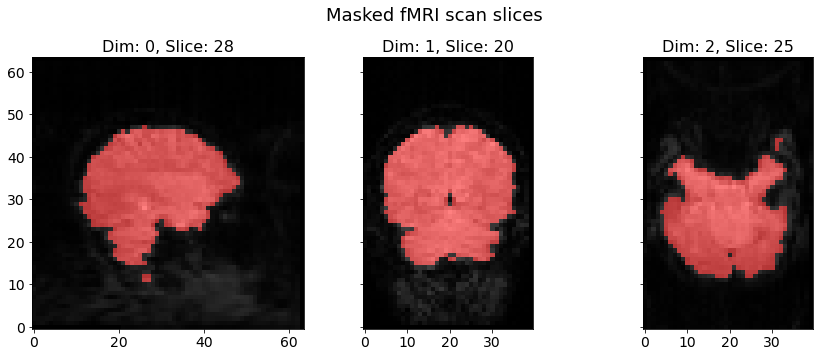

In [252]:
show_scan_slices(fMRI_face[10], [28, 20, 25], binary_mask, save_img=False)

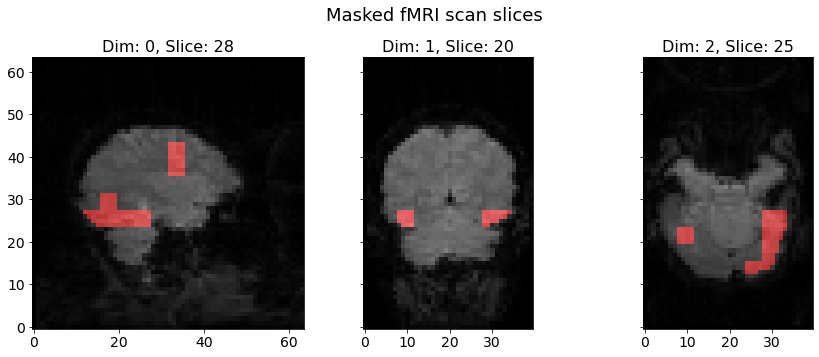

In [253]:
fMRI_face = X[42]
s_face = s[42]

# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 30

s_face[s_face!=0]=1

# Get active mask using CCW method
active_mask = ccw(fMRI_face, s_face, mu, k_s, Delta_t, h)

# Cut the mask along the outline of the brain
mask = torch.tensor(brain_mask) * active_mask


show_scan_slices(fMRI_face[10], [28, 20, 25], mask, save_img=True)

---
Попробуем предсказать области по ряду изменений фМРТ и ряду изменений стимула, то есть рассмотретим временные ряды delta_s=s[k+1]-s[k] и delta_fMRI (аналогично).

In [180]:
bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1

delta_bin_stimuli = np.diff(bin_stimuli)

delta_fmri = np.diff(fmris_transposed, axis=0)

In [206]:
# Set parameters
k_s = 4
Delta_t = 0.0
mu=2.5
h = 100


# Get active mask using CCW method
active_mask = ccw(delta_fmri, delta_bin_stimuli, mu, k_s, Delta_t, h)

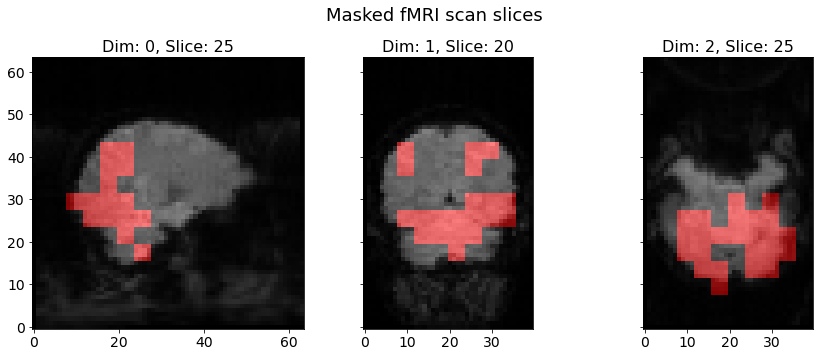

In [207]:
show_scan_slices(fmris_transposed[0], [25, 20, 25], active_mask, save_img=True)

Ощущение, что качество стало значительно лучше

----
#### Фильтрация

In [225]:
from scipy.signal import butter, lfilter

def high_pass_filter(data, cutoff=0.01, sample_rate=2.5):
    """
    Apply high-pass filter to the data.
    :param data: Input data (torch.Tensor of shape (time, x, y, z)).
    :param cutoff: Cutoff frequency.
    :param sample_rate: Sample rate of the data.
    :return: Filtered data.
    """
    # Calculate the filter coefficients
    normal_cutoff = cutoff / (sample_rate / 2)
    b, a = butter(2, normal_cutoff, 'highpass')

    # Convert the coefficients to PyTorch tensors
    b_tensor = torch.tensor(b, dtype=torch.float32)
    a_tensor = torch.tensor(a, dtype=torch.float32)

    # Apply the filter to the data along the time dimension
    filtered_data = torch.zeros_like(torch.tensor(data))
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            for k in range(data.shape[3]):
                filtered_signal = lfilter(b_tensor, a_tensor, data[:, i, j, k])
                filtered_data[:, i, j, k] = torch.tensor(filtered_signal)
    return filtered_data

def low_pass_filter(data, cutoff=0.2, sample_rate=2.5):
    """
    Apply low-pass filter to the data.
    :param data: Input data (torch.Tensor of shape (time, x, y, z)).
    :param cutoff: Cutoff frequency.
    :param sample_rate: Sample rate of the data.
    :return: Filtered data.
    """
    # Calculate the filter coefficients
    normal_cutoff = cutoff / (sample_rate / 2)
    b, a = butter(2, normal_cutoff, 'lowpass')

    # Convert the coefficients to PyTorch tensors
    b_tensor = torch.tensor(b, dtype=torch.float32)
    a_tensor = torch.tensor(a, dtype=torch.float32)

    # Apply the filter to the data along the time dimension
    filtered_data = torch.zeros_like(torch.tensor(data))
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            for k in range(data.shape[3]):
                filtered_signal = lfilter(b_tensor, a_tensor, data[:, i, j, k])
                filtered_data[:, i, j, k] = torch.tensor(filtered_signal)
    return filtered_data

Делает лишь хуже